In [153]:
# importing and general setup
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


def fixpath(path):
    if path.startswith("C:"): return "/mnt/c/" + path.replace("\\", "/")[3:]
    else:
        pass
    return path

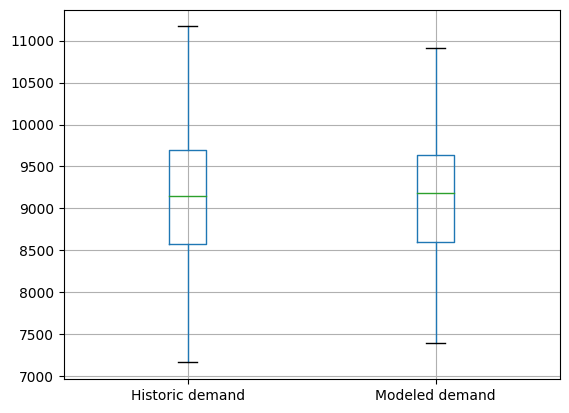

In [57]:
# load curve cross validation
path = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_demand_supply\demand_projection")
load_curve = pd.read_excel(Path(path, "DESSTINEE Electricity Profiles for 2010 - 2023-04-12 16-29-14.xlsb"), sheet_name='AB', engine='pyxlsb', skiprows=1, header=0, index_col=2)

load_compare = load_curve[['total_model', 'cal_total']].iloc[0:8760]
load_compare.rename(columns={'total_model': 'Historic demand', 'cal_total': 'Modeled demand'}, inplace=True)

'''q75,q25 = np.percentile(load_compare['Modeled demand'],[75,25])
intr_qr = q75-q25
max = q75+(1.5*intr_qr)
min = q25-(1.5*intr_qr)
load_compare.loc[load_compare['Modeled demand'] > max, 'Modeled demand'] = np.nan
load_compare.loc[load_compare['Modeled demand'] < min, 'Modeled demand'] = np.nan
load_compare = load_compare.dropna()'''

load_compare.boxplot()
plt.show()


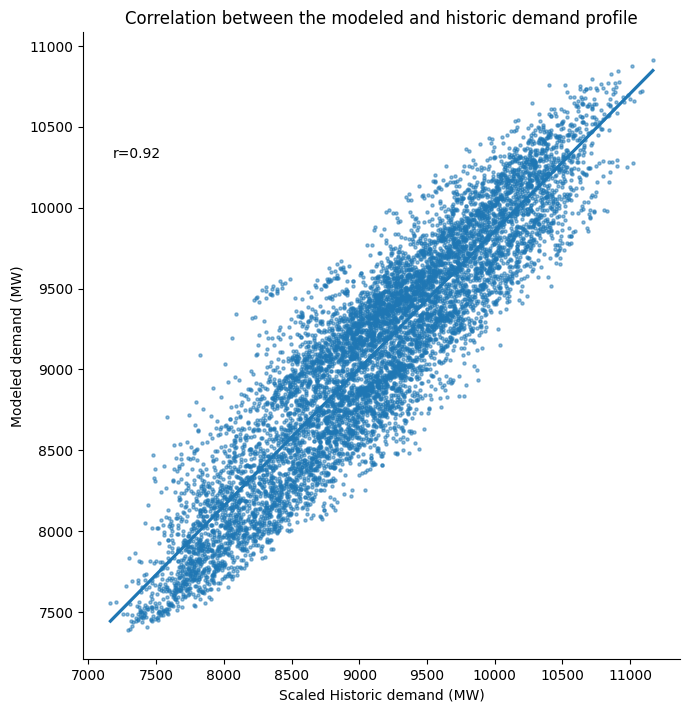

In [73]:
# correlation graph
r, p = stats.pearsonr(load_compare['Historic demand'], load_compare['Modeled demand'])
lm = sns.lmplot(x='Historic demand', y='Modeled demand', data=load_compare, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('Correlation between the modeled and historic demand profile')
plt.xlabel('Scaled Historic demand (MW)')
plt.text(0.05, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Modeled demand (MW)')
plt.savefig(Path(path, 'load_curve_validation.png'), dpi=300, bbox_inches='tight')
plt.show()

In [78]:
# t-test for the demand curve
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
load_compare['Historic demand_norm'] = scaler.fit_transform(load_compare['Historic demand'].values.reshape(-1, 1))
load_compare['Modeled demand_norm'] = scaler.fit_transform(load_compare['Modeled demand'].values.reshape(-1, 1))
rand_range = np.random.randint(0, 8760, 30)
print(stats.ttest_ind(load_compare['Historic demand_norm'].iloc[rand_range], load_compare['Modeled demand_norm'].iloc[rand_range], equal_var=False))
print(stats.mannwhitneyu(load_compare['Historic demand_norm'].iloc[rand_range], load_compare['Modeled demand_norm'].iloc[rand_range]))
print(mean_squared_error(load_compare['Historic demand_norm'].iloc[rand_range], load_compare['Modeled demand_norm'].iloc[rand_range]))
print(mean_absolute_error(load_compare['Historic demand_norm'].iloc[rand_range], load_compare['Modeled demand_norm'].iloc[rand_range]))
print(mean_squared_error(load_compare['Historic demand'].iloc[rand_range], load_compare['Modeled demand'].iloc[rand_range]))
print(mean_absolute_error(load_compare['Historic demand'].iloc[rand_range], load_compare['Modeled demand'].iloc[rand_range]))

Ttest_indResult(statistic=0.017290511274880543, pvalue=0.9862642092773339)
MannwhitneyuResult(statistic=436.0, pvalue=0.8418014501581275)
0.006484491191231545
0.07091890398627256
99131.95298159058
267.488279583103


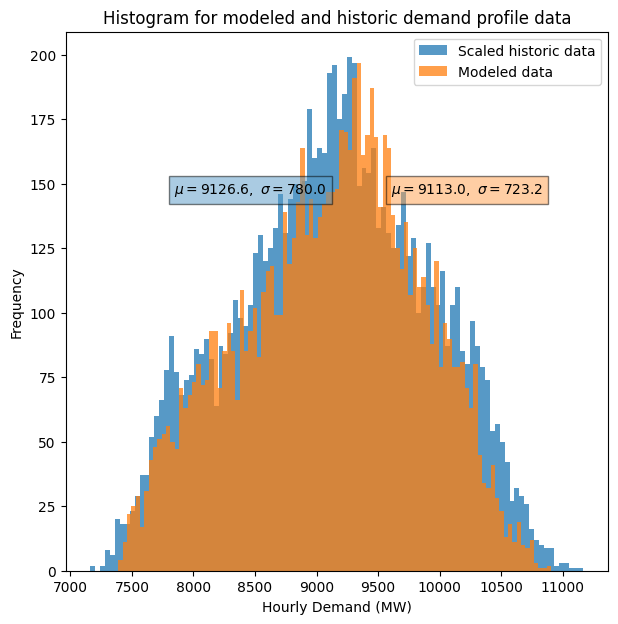

In [72]:
# histogram for the demand curves

fig, ax = plt.subplots(figsize=(7, 7))
plt.hist(load_compare['Historic demand'], bins=100, alpha=0.75)
plt.hist(load_compare['Modeled demand'], bins=100, alpha=0.75)
plt.title('Histogram for modeled and historic demand profile data')
plt.xlabel('Hourly Demand (MW)')
plt.ylabel('Frequency')
plt.legend(labels = ['Scaled historic data', 'Modeled data'])
plt.text(0.2, 0.7, f"$\mu= {load_compare['Historic demand'].mean(): .1f}, \ \sigma= {load_compare['Historic demand'].std(): .1f}$",
         transform = ax.transAxes, bbox = dict(facecolor = '#5799c6', alpha = 0.5))
plt.text(0.6, 0.7, f"$\mu= {load_compare['Modeled demand'].mean(): .1f}, \ \sigma= {load_compare['Modeled demand'].std(): .1f}$",
         transform = ax.transAxes, bbox = dict(facecolor = '#ff9f4b', alpha = 0.5))
plt.savefig(Path(path,'hist_load.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
    for index in random_dates:
        
        currentmonth = index.month
        currentday = index.day
        hour = index.hour

        if currentmonth != lastmonth:
            monthly_hours = 0
            if lastmonth == 0:
                htgfile.write(F'{Rubystringhtg}(\"IF (Month == {index.month}) \") \n' )
            else:
                if lastday != 0:
                    htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n') # matching if: day == 1 or hour == 14?
                htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n') # matching if = day == 1 or hour == 14?
                htgfile.write(F'{Rubystringhtg}(\"ELSEIF (Month == {index.month}) \") \n' )             
        
        if currentday != lastday:
            if monthly_hours == 0:           
                htgfile.write(F'{Rubystringhtg}(\"IF (DayOfMonth == {index.day}) \") \n' )
            elif changed_sp.loc[changed_sp.index.day == currentday-1,'changed'].any():
                        htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n')
                        htgfile.write(F'{Rubystringhtg}(\"ELSEIF (DayOfMonth == {index.day}) \") \n' )
                    
        #decrease the setpoint
        if hour == 0:
            htgfile.write(F'{Rubystringhtg}(\"IF (Hour == {hour}) \") \n' )
        else:
            htgfile.write(F'{Rubystringhtg}(\"ELSEIF (Hour == {hour}) \") \n' )
        htgfile.write(F'{Rubystringhtg}(\"SET #{{ems_htg_sch_actuator.name}} = {temp[0]}\") \n')
        changed_sp['changed'].loc[index] = True

        monthly_hours += 1

        lastmonth = currentmonth
        lastday = currentday

In [48]:
# SA for building model in winter
import os
import shutil
from distutils.dir_util import copy_tree

cwd = '/mnt/c/users/smoha/documents/git/etl-visuals/validation'
pwd = os.path.dirname(cwd)


#testing with only 5 months
#lmp_hourly = lmp_hourly.loc[lmp_hourly.index.month == [1,2,3,4]]

Rubystringhtg = 'ems_htg_setpoint_prg.addLine'
Rubystringclg = 'ems_clg_setpoint_prg.addLine'

from scipy.stats.qmc import LatinHypercube as LH

# Create a Latin Hypercube sampler
engine = LH(1)
min_sp_winter = 15 + engine.random(30)*10
mean_sp_winter = 21

lastmonth = 0
lastday = 0
setpoint_counter = 0
monthly_hours = 0

date_range = pd.date_range(start = '2006-01-01', end='2006-03-01', freq='H')
random_dates = pd.to_datetime(
    np.concatenate([
            np.random.choice(date_range[1:-1], size=1, replace=False)
        ])
    )
changed_sp = pd.DataFrame(index = range, columns=['changed'])

for num, temp in enumerate(min_sp_winter):
    lastmonth = 0
    lastday = 0
    setpoint_counter = 0
    monthly_hours = 0
    iter = f'iter{num}'
    sen = os.path.join(pwd, 'temp', f'building_{iter}')
    os.makedirs(sen, exist_ok=True)
    os.chdir(sen)
    htgfile = open(f'htg_measure_{iter}.txt', 'w+')

    for index in random_dates:
        
        currentmonth = index.month
        currentday = index.day
        hour = index.hour

        if currentmonth != lastmonth:
            monthly_hours = 0
            if lastmonth == 0:
                htgfile.write(F'{Rubystringhtg}(\"IF (Month == {index.month}) \") \n' )
            else:
                if lastday != 0:
                    htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n') # matching if: day == 1 or hour == 14?
                htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n') # matching if = day == 1 or hour == 14?
                htgfile.write(F'{Rubystringhtg}(\"ELSEIF (Month == {index.month}) \") \n' )             
        
        if currentday != lastday:
            if monthly_hours == 0:           
                setpoint_counter = 0
                htgfile.write(F'{Rubystringhtg}(\"IF (DayOfMonth == {index.day}) \") \n' )
            elif changed_sp.loc[changed_sp.index.day == currentday-1,'changed'].any():
                        htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n')
                        htgfile.write(F'{Rubystringhtg}(\"ELSEIF (DayOfMonth == {index.day}) \") \n' )
                    
        #decrease the setpoint
        if setpoint_counter == 0:
            htgfile.write(F'{Rubystringhtg}(\"IF (Hour == {hour}) \") \n' )
        else:
            htgfile.write(F'{Rubystringhtg}(\"ELSEIF (Hour == {hour-1}) \") \n' )
        htgfile.write(F'{Rubystringhtg}(\"SET #{{ems_htg_sch_actuator.name}} = {temp[0]}\") \n')
        changed_sp['changed'].loc[index] = True

        monthly_hours += 1
        setpoint_counter += 1
        lastmonth = currentmonth
        lastday = currentday


    # setpoint for non-curtailment hours
    htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n')
    htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n')
    htgfile.write(F'{Rubystringhtg}(\"ELSE\")\n')
    htgfile.write(F'{Rubystringhtg}(\"SET #{{ems_htg_sch_actuator.name}} = {mean_sp_winter}\")\n')
    htgfile.write(F'{Rubystringhtg}(\"ENDIF\")\n')  # matching "if" = January (if month == 1)

    htgfile.close()

    shutil.copy2(f'{pwd}/measure.rb', sen)

    with open(f'htg_measure_{iter}.txt', 'rt') as htg_mes:
        tstat_lines = htg_mes.readlines()

    os.chdir(sen)
    with open('measure.rb', 'rt') as measure_file:
        measure_lines = measure_file.readlines()

    with open('measure.rb', 'w') as measure_file:
        for i,line in enumerate(measure_lines):
            if i == 43:
                measure_file.writelines(f'    return "{iter}_SA Computed Schedule"')
            elif i == 353:
                measure_file.writelines('    ' + lin for lin in tstat_lines)
            else:
                measure_file.writelines(line)
    if num != 0:    
        os.makedirs(f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_{iter}/', exist_ok=True)
        copy_tree(f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_iter{num-1}', f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_{iter}')
    shutil.copy2(f'measure.rb', f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_{iter}/')
    os.chdir(pwd)
    print(iter)

iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
iter18
iter19
iter20
iter21
iter22
iter23
iter24
iter25
iter26
iter27
iter28
iter29


In [171]:
# Reading energy values
import glob

os.chdir(fixpath(r'C:\Users\smoha\Documents\archetypes_base\SA_temp'))
house_type_fn = ['Apartment Shape', 'new house shape', 'old house shape']
combined_energy_hour = pd.DataFrame()
for name in house_type_fn:
    newhouseshape_fn = [i for i in glob.glob(f'{name}*Heating*.csv')]
    header = [i.split('_')[1] for i in newhouseshape_fn]
    combined_energy = pd.concat([(pd.read_csv(f, index_col='Hourly')) for f in newhouseshape_fn], axis=1)
    combined_energy.columns = header
    combined_energy.loc['iter'] = combined_energy.columns.str.replace('iter','').astype(int)
    combined_energy.columns = combined_energy.loc['iter']
    combined_energy_hour[name] = combined_energy.iloc[1266]*0.000000278

combined_energy_hour.sort_index(inplace=True)

In [128]:
temp_SA = pd.DataFrame(min_sp_winter)
temp_SA.columns = ['setpoint']


In [178]:
sa_cross = pd.concat([temp_SA, combined_energy_hour], axis=1)
sa_cross.to_csv(Path(path,f'SA_cross.csv'))

In [177]:
# Scatter plot for heating vs setpoints
path = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_demand_supply\validation")


for i, name in enumerate(house_type_fn):
    lm = sns.lmplot(x='setpoint', y=name, data=sa_cross, height=5, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
    ax = lm.axes[0,0]
    r, p = stats.pearsonr(sa_cross['setpoint'], sa_cross[name])
    plt.title(f'{name.capitalize()}')
    plt.xlabel('Setpoint ($^\circ$C)')
    plt.text(0.05, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
    plt.ylabel('Energy demand (kWh)')
    plt.savefig(Path(path,f'setpoint_SA{name}.png'), dpi=300, bbox_inches='tight')

In [226]:
# SA for building model in summer
import os
import shutil
from distutils.dir_util import copy_tree

cwd = '/mnt/c/users/smoha/documents/git/etl-visuals/validation'
pwd = os.path.dirname(cwd)


#testing with only 5 months
#lmp_hourly = lmp_hourly.loc[lmp_hourly.index.month == [1,2,3,4]]

Rubystringclg = 'ems_htg_setpoint_prg.addLine'
Rubystringclg = 'ems_clg_setpoint_prg.addLine'

from scipy.stats.qmc import LatinHypercube as LH

# Create a Latin Hypercube sampler
engine = LH(1)
min_sp_summer = 16 + engine.random(30)*10
mean_sp_summer = 23

lastmonth = 0
lastday = 0
setpoint_counter = 0
monthly_hours = 0

date_range = pd.date_range(start = '2006-08-15 14:00:00', end='2006-08-15 16:00:00', freq='H')
random_dates = pd.to_datetime(
    np.concatenate([
            np.random.choice(date_range[1:-1], size=1, replace=False)
        ])
    )

#random_dates = pd.to_datetime('2006-07-15 16:00:00')
changed_sp = pd.DataFrame(index = range, columns=['changed'])

for num, temp in enumerate(min_sp_summer):
    lastmonth = 0
    lastday = 0
    setpoint_counter = 0
    monthly_hours = 0
    iter = f'iter{num}'
    sen = os.path.join(pwd, 'temp', f'building_{iter}')
    os.makedirs(sen, exist_ok=True)
    os.chdir(sen)
    clgfile = open(f'clg_measure_{iter}.txt', 'w+')

    for index in random_dates:
        
        currentmonth = index.month
        currentday = index.day
        hour = index.hour

        if currentmonth != lastmonth:
            monthly_hours = 0
            if lastmonth == 0:
                clgfile.write(F'{Rubystringclg}(\"IF (Month == {index.month}) \") \n' )
            else:
                if lastday != 0:
                    clgfile.write(F'{Rubystringclg}(\"ENDIF\")\n') # matching if: day == 1 or hour == 14?
                clgfile.write(F'{Rubystringclg}(\"ENDIF\")\n') # matching if = day == 1 or hour == 14?
                clgfile.write(F'{Rubystringclg}(\"ELSEIF (Month == {index.month}) \") \n' )             
        
        if currentday != lastday:
            if monthly_hours == 0:           
                setpoint_counter = 0
                clgfile.write(F'{Rubystringclg}(\"IF (DayOfMonth == {index.day}) \") \n' )
            elif changed_sp.loc[changed_sp.index.day == currentday-1,'changed'].any():
                        clgfile.write(F'{Rubystringclg}(\"ENDIF\")\n')
                        clgfile.write(F'{Rubystringclg}(\"ELSEIF (DayOfMonth == {index.day}) \") \n' )
                    
        #decrease the setpoint
        if setpoint_counter == 0:
            clgfile.write(F'{Rubystringclg}(\"IF (Hour == {hour}) \") \n' )
        else:
            clgfile.write(F'{Rubystringclg}(\"ELSEIF (Hour == {hour-1}) \") \n' )
        clgfile.write(F'{Rubystringclg}(\"SET #{{ems_clg_sch_actuator.name}} = {temp[0]}\") \n')
        changed_sp['changed'].loc[index] = True

        monthly_hours += 1
        setpoint_counter += 1
        lastmonth = currentmonth
        lastday = currentday


    # setpoint for non-curtailment hours
    clgfile.write(F'{Rubystringclg}(\"ENDIF\")\n')
    clgfile.write(F'{Rubystringclg}(\"ENDIF\")\n')
    clgfile.write(F'{Rubystringclg}(\"ELSE\")\n')
    clgfile.write(F'{Rubystringclg}(\"SET #{{ems_clg_sch_actuator.name}} = {mean_sp_summer}\")\n')
    clgfile.write(F'{Rubystringclg}(\"ENDIF\")\n')  # matching "if" = January (if month == 1)

    clgfile.close()

    shutil.copy2(f'{pwd}/measure.rb', sen)

    with open(f'clg_measure_{iter}.txt', 'rt') as clg_mes:
        tstat_lines = clg_mes.readlines()

    os.chdir(sen)
    with open('measure.rb', 'rt') as measure_file:
        measure_lines = measure_file.readlines()

    with open('measure.rb', 'w') as measure_file:
        for i,line in enumerate(measure_lines):
            if i == 43:
                measure_file.writelines(f'    return "{iter}_SA Computed Schedule"\n')
            elif i == 272:
                measure_file.writelines('    ' + lin for lin in tstat_lines)
            else:
                measure_file.writelines(line)
    if num != 0:    
        os.makedirs(f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_{iter}/', exist_ok=True)
        copy_tree(f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_iter0', f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_{iter}')
    shutil.copy2(f'measure.rb', f'/mnt/c/users/smoha/documents/archetypes_base/measures/DR_measure_setpoint_{iter}/')
    os.chdir(pwd)
    print(iter)

iter0
iter1
iter2
iter3
iter4
iter5
iter6
iter7
iter8
iter9
iter10
iter11
iter12
iter13
iter14
iter15
iter16
iter17
iter18
iter19
iter20
iter21
iter22
iter23
iter24
iter25
iter26
iter27
iter28
iter29


In [227]:
temp_SA = pd.DataFrame(min_sp_summer)
temp_SA.columns = ['setpoint']

In [232]:
# Reading energy values
import glob

os.chdir(fixpath(r'C:\Users\smoha\Documents\archetypes_base\SA_temp'))
house_type_fn = ['Apartment Shape', 'new house shape', 'old house shape']
combined_energy_hour = pd.DataFrame()
for name in house_type_fn:
    newhouseshape_fn = [i for i in glob.glob(f'{name}*Cooling*.csv')]
    header = [i.split('_')[1] for i in newhouseshape_fn]
    header = [int(i.replace('iter', '')) for i in header]
    combined_energy = pd.concat([(pd.read_csv(f, index_col='Hourly')) for f in newhouseshape_fn], axis=1)
    combined_energy.columns = header
    combined_energy.index = pd.to_datetime(combined_energy.index)
    combined_energy_hour[name] = combined_energy.iloc[5439].transpose()

combined_energy_hour.sort_index(inplace=True)

In [235]:
sa_cross = pd.concat([temp_SA, combined_energy_hour], axis=1)
sa_cross.to_csv(Path(path,f'SA_cross.csv'))
sa_cross.dropna(inplace=True)

In [236]:
# Scatter plot for heating vs setpoints for summer
path = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_demand_supply\validation")


for i, name in enumerate(house_type_fn):
    lm = sns.lmplot(x='setpoint', y=name, data=sa_cross, height=5, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
    ax = lm.axes[0,0]
    r, p = stats.pearsonr(sa_cross['setpoint'], sa_cross[name])
    plt.title(f'{name.capitalize()}')
    plt.xlabel('Setpoint ($^\circ$C)')
    plt.text(0.05, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
    plt.ylabel('Energy demand (kWh)')
    plt.savefig(Path(path,f'setpoint_SA{name}.png'), dpi=300, bbox_inches='tight')